<a href="https://colab.research.google.com/github/Rajora0/avaliacao_daedalus/blob/main/question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.4 MB/s eta 0:00:00


In [2]:
%%bash 
gdown 'https://drive.google.com/uc?export=download&id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT'
gdown 'https://drive.google.com/uc?export=download&id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb'
gdown 'https://drive.google.com/uc?export=download&id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW'

Downloading...
From: https://drive.google.com/uc?export=download&id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT
To: /content/post-processed.zip
100%|██████████| 71.4M/71.4M [00:01<00:00, 54.9MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb
To: /content/marcelinho_no_db.jpg
100%|██████████| 37.5k/37.5k [00:00<00:00, 70.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW
To: /content/marcelinho_na_inferencia.jpg
100%|██████████| 87.6k/87.6k [00:00<00:00, 120MB/s]


In [3]:
%%bash 
rm -rf post-processed
rm -rf new_data
mkdir new_data
mkdir new_data/marcelinho
unzip -q post-processed.zip
mv marcelinho_no_db.jpg new_data/marcelinho/
rm post-processed.zip
ls

marcelinho_na_inferencia.jpg
new_data
post-processed
sample_data


In [15]:
import os
import pickle
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.models import resnet18

In [5]:
# Função para processar imagem
def process_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    return img

In [6]:
def load_data():
    # Carregue as imagens e crie os rótulos com base nos nomes das pastas
    root_dir = "post-processed"
    folders = [os.path.join(root_dir, folder) for folder in os.listdir(root_dir)]
    images = []
    labels = []

    for folder in folders:
        current_label = os.path.basename(folder)
        image_paths = glob(os.path.join(folder, "*.jpg"))
        for image_path in image_paths:
            image = process_image(image_path)
            images.append(image)
            labels.append(current_label)

    return images,labels

In [7]:
images, labels = load_data()

In [8]:
def load_pretrained_model():
    global model
    global device
    # Verifique se a GPU está disponível
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Carregue o modelo pré-treinado e remova a última camada
    model = resnet18(pretrained=True)
    model = torch.nn.Sequential(*(list(model.children())[:-1])).to(device)
    model.eval()
    
    return 

In [9]:
load_pretrained_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 270MB/s]


In [10]:
def create_database(images, labels, model, device):

    global image_transform
    # Transformação para a imagem
    image_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Calcula os descritores e salva em descritores_images
    descritores_images = []
    for image in tqdm(images, desc="Processing"):
        image = image_transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model(image)
        descritores_images.append(features.squeeze().cpu().numpy())

    descritores_images = np.vstack(descritores_images)

    # Salva os descritores e rótulos em um arquivo pickle
    data = {"descriptors": descritores_images, "labels": labels}
    with open("image_descriptors_labels.pkl", "wb") as f:
        pickle.dump(data, f)

    return data

In [11]:
create_database(images, labels, model, device)

Processing:   0%|          | 0/12000 [00:00<?, ?it/s]

{'descriptors': array([[0.12276334, 2.8356783 , 2.0443065 , ..., 1.8900566 , 0.1417086 ,
         0.23194589],
        [0.12754259, 1.4034218 , 1.6477661 , ..., 1.6164619 , 0.09869888,
         0.042291  ],
        [0.01712968, 1.3222041 , 0.42365888, ..., 0.9751213 , 0.7720732 ,
         0.09801481],
        ...,
        [1.046505  , 0.9735572 , 0.7216957 , ..., 0.24713804, 0.06994581,
         0.86048436],
        [0.3082241 , 1.5374024 , 0.4893195 , ..., 1.448236  , 0.16366597,
         0.31518614],
        [1.2438681 , 2.081731  , 1.9184456 , ..., 0.5695709 , 0.5674898 ,
         0.3221227 ]], dtype=float32),
 'labels': ['Steve_Nesbitt',
  'Steve_Nesbitt',
  'Claudia_Cardinale',
  'Claudia_Cardinale',
  'Hugh_Jessiman',
  'Hugh_Jessiman',
  'Jim_Otto',
  'Jim_Otto',
  'Nicolas_Lapentti',
  'Nicolas_Lapentti',
  'Nicolas_Lapentti',
  'Paul_McCartney',
  'Paul_McCartney',
  'Paul_McCartney',
  'Paul_McCartney',
  'Paul_McCartney',
  'Paul_McCartney',
  'Paul_McCartney',
  'Paul_McCar

In [12]:
def load_pickle_data(file_name):
    # Carrega o arquivo pickle
    with open(file_name, 'rb') as f:
        data = pickle.load(f)

    # Separa as componentes em descritores_images e labels
    descritores_images = data['descriptors']
    labels = data['labels']

    return descritores_images, labels

In [13]:
def update_pickle_data(new_data_folder, pickle_file, model, device):
    # Carregue as imagens e crie os rótulos com base nos nomes das pastas
    root_dir = new_data_folder
    folders = [os.path.join(root_dir, folder) for folder in os.listdir(root_dir)]
    images = []
    labels = []

    for folder in folders:
        current_label = os.path.basename(folder)
        image_paths = glob(os.path.join(folder, "*.jpg"))
        for image_path in image_paths:
            image = process_image(image_path)
            images.append(image)
            labels.append(current_label)

    # Crie novos descritores para as novas imagens
    new_data = create_database(images, labels, model, device)

    # Carregue os dados atuais do arquivo pickle
    descritores_images, current_labels = load_pickle_data(pickle_file)

    # Atualize os descritores e rótulos
    updated_descriptors = np.vstack([descritores_images, new_data["descriptors"]])
    updated_labels = current_labels + new_data["labels"]

    # Salve os descritores e rótulos atualizados em um arquivo pickle
    updated_data = {"descriptors": updated_descriptors, "labels": updated_labels}
    with open(pickle_file, "wb") as f:
        pickle.dump(updated_data, f)

    plt.title(f'Example: {labels[0]}')
    plt.imshow(images[0])
    plt.show()

    

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

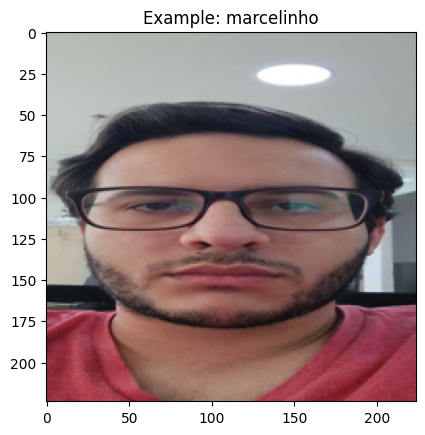

In [16]:
update_pickle_data("new_data", "image_descriptors_labels.pkl", model, device)

In [17]:
def calculate_descriptor(image_path, model, image_transform, device='cuda'):
    # Função para processar imagem
    def process_image(image_path):
        img = Image.open(image_path)
        img = img.resize((224, 224))
        return img
    
    # Carregue a imagem
    image = process_image(image_path)

    # Aplique a transformação na imagem
    transformed_image = image_transform(image).unsqueeze(0).to(device)

    # Extraia os recursos (descritores) da imagem transformada usando o modelo
    with torch.no_grad():
        features = model(transformed_image)

    # Retorna os descritores da imagem após a transformação
    return image, features.squeeze().cpu().numpy()

### Métricas 

In [18]:
import numpy as np
from collections import Counter
from scipy.stats import norm

In [19]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def gaussian_density(distance, sigma=1):
    return norm.pdf(distance, loc=0, scale=sigma)

def softmax(x, temperature=1):
    e_x = np.exp((x - np.max(x))/temperature)
    return e_x / e_x.sum(axis=0)

def highest_softmax_metric(image_descriptors, descritores_images, labels, temperature=0.01, sigma=1):

    distances = np.array([euclidean_distance(image_descriptors, desc) for desc in descritores_images])

    probabilities = gaussian_density(distances, sigma=sigma)

    label_probabilities = Counter()
    label_count = Counter(labels)
    for label, prob in zip(labels, probabilities):
        label_probabilities[label] += prob

    for label in label_probabilities:
        label_probabilities[label] /= label_count[label]

    predicted_probabilities = dict(label_probabilities)

    adjusted_probabilities = softmax(list(predicted_probabilities.values()), temperature=temperature)

    adjusted_probabilities_dict = dict(zip(predicted_probabilities.keys(), adjusted_probabilities*100))

    sorted_probabilities = sorted(adjusted_probabilities_dict.items(), key=lambda x: x[1], reverse=True)

    return sorted_probabilities[0]


### Inferencia

In [20]:
image_path = 'marcelinho_na_inferencia.jpg'

In [21]:
descritores_images, labels = load_pickle_data("image_descriptors_labels.pkl")

In [22]:
image, image_descriptors = calculate_descriptor(image_path, model, image_transform, device='cuda')

In [23]:
highest_softmax = highest_softmax_metric(image_descriptors, descritores_images, labels)
predicted_label, highest_probability = highest_softmax

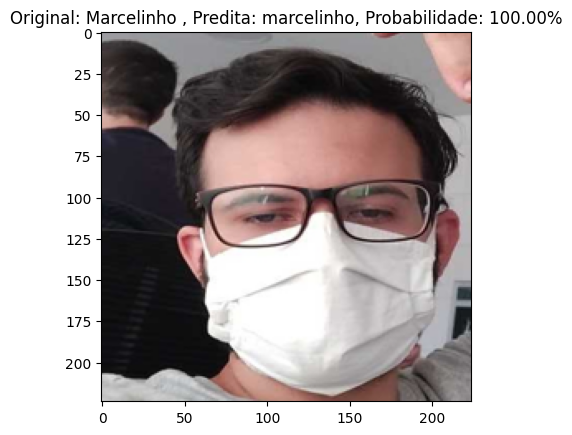

In [24]:
plt.imshow(image)
plt.title(f"Original: Marcelinho , Predita: {predicted_label}, Probabilidade: {highest_probability:.2f}%")
plt.show()